<a href="https://colab.research.google.com/github/teofizzy/mlfc-miniproject/blob/main/notebooks/CDS_climatology_miniproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLFC Miniproject submission**

Name: Teofilo Ligawa

Github repository [link](https://github.com/teofizzy/mlfc-miniproject.git)
## Abstract
Using ERA5 monthly averaged temperature data (1979–2024), we investigated regional warming trends across six representative African subregions: the Sahel, East Africa, Central Africa, the Congo Basin, Southern Africa, and the Sahara. Results show that all regions are experiencing significant warming, with rates ranging from 0.19 to 0.44 °C per decade. The Sahara emerges as the fastest-warming and most variable region, followed by the Congo Basin and Sahel. East and Southern Africa display more moderate warming but remain consistently above the 1991–2020 climatological baseline in the last decade. These findings highlight the heterogeneity of climate change impacts across Africa, with desert and rainforest regions showing particularly strong warming signals.

In [1]:
# Install requirements
!pip install cdsapi cartopy xarray osmnx --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 5.2 MB/s eta 0:00:00


In [2]:
# @title Google Auths
from google.colab import userdata, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title Github and CDS credentials
github_token = userdata.get('GITHUB_TOKENS')
github_username = userdata.get('GITHUB_USERNAME')
github_email = userdata.get('GITHUB_EMAIL')
cds_api_key = userdata.get('CDS_API_KEY')

In [4]:
!git clone https://github.com/teofizzy/mlfc-miniproject.git

Cloning into 'mlfc-miniproject'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 124 (delta 9), reused 115 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (124/124), 24.51 MiB | 4.27 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (108/108), done.


In [5]:
# dependencies
import cdsapi

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.path as mpath

import urllib3
urllib3.disable_warnings()


#### Access data

We shall get data from the [CDS website](http://cds.climate.copernicus.eu).

The data used here is the [ERA5 monthly averaged data on single levels from 1979 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview). ERA5 is the 5th version of the ECMWF Reanalysis dataset.

Having selected our dataset of interest, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. Essentially these are the parameters we use to make the download.

- Product type: `Monthly averaged reanalysis`
- Variable: `2m temperature`
- Year: `1979 to year before present`
- Month: `all`
- Time: `00:00` (default)
- Geographical area: `Africa`
- Format: `NetCDF`

In [6]:
import os
os.listdir()

['.config', 'mlfc-miniproject', 'drive', 'sample_data']

In [7]:
os.chdir('mlfc-miniproject')

In [8]:
URL='https://cds.climate.copernicus.eu/api'

In [9]:
client = cdsapi.Client(url=URL, key=cds_api_key)

2025-09-22 23:11:08,675 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-22 23:11:08,677 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


In [10]:
## -- parameters for the download -- ##

# Years of interest
years = [str(year) for year in range(1979, 2025)]

# Months of the year
months = [f'{month:02d}' for month in range(1, 13)]

# Time (hours of the day)
time = ['00:00']
# Area in latitude and longitude (north, west, south, east)
area = [38, -18, -35, 52,]

# Dataset, variable, product type, destination path
dataset = 'reanalysis-era5-single-levels-monthly-means' # dataset
t2m_var = '2m_temperature' # temperature

product_type = 'monthly_averaged_reanalysis' # product type

destination_dir = '/content/drive/MyDrive/CDS-data'

t2m_filename = 'era5_monthly_2m_temperature_africa.nc'

In [11]:
from fynesse.access import download_monthly_data

In [12]:
# Download monthly temperature data
t2m_monthly_1979_2024 = download_monthly_data(client, year=years, month=months, time=time,
                                              area=area, dataset=dataset, variable=t2m_var,
                                              product_type=product_type, destination_dir=destination_dir,
                                              filename=t2m_filename)

2025-09-22 23:11:16,875 INFO Request ID is 7ca398d7-c8f8-4b81-b86a-963f4ab1a1e0
INFO:ecmwf.datastores.legacy_client:Request ID is 7ca398d7-c8f8-4b81-b86a-963f4ab1a1e0
2025-09-22 23:11:17,128 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-09-22 23:11:26,198 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-09-22 23:12:34,050 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


918b89c833d018b3d5059f4062af9873.nc:   0%|          | 0.00/66.0M [00:00<?, ?B/s]

In [17]:
# open dataset
t2m_ds = xr.open_dataset(f'{destination_dir}/{t2m_filename}')
print(t2m_ds)

<xarray.Dataset> Size: 182MB
Dimensions:     (valid_time: 552, latitude: 293, longitude: 281)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 2kB 38.0 37.75 37.5 ... -34.5 -34.75 -35.0
  * longitude   (longitude) float64 2kB -18.0 -17.75 -17.5 ... 51.5 51.75 52.0
    expver      (valid_time) <U4 9kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 182MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-22T23:12 GRIB to CDM+CF via cfgrib-0.9.1...


## 1. Basic cleaning steps

In [18]:
# Drop unnecessary coordinates and rename time
t2m_ds = t2m_ds.drop_vars(['number', 'expver'])
t2m_ds = t2m_ds.rename({'valid_time': 'time'})

In [19]:
# create data array
t2m_da = t2m_ds['t2m'] # temperature

Default values of ERA-5 temperature data are in units of Kelvin, the base unit for temperature in the International System of Units (SI). To convert the values from Kelvin to degrees Celsius, you have to subtract 273.15.

In [20]:
# convert units
t2m_da = t2m_da - 273.15 # kelvin to Celcius

In [21]:
# reassign attributes
t2m_da = t2m_da.assign_attrs(t2m_ds.t2m.attrs)

t2m_da.attrs['units'] = '° C'

In [22]:
# Get the data array dimensions and shape
print(t2m_da.shape)
print(t2m_da.dims)

(552, 293, 281)
('time', 'latitude', 'longitude')


In [23]:
# subregion bounding boxes - rough estimates from wikipedia
sahel_area = [20.0, -18.0, 8.0, 36.0]
east_africa_area = [16.0, 28.0, -12.0, 52.0]
central_africa_area = [12.0, 8.0, -12.0, 31.0]
congo_basin_area = [6.0, 12.0, -8.0, 31.0]
southern_africa_area = [-8.0, 10.0, -35.0, 40.0]
sahara_area = [31.0, -18.0, 18.0, 52.0]

In [24]:
from fynesse.access import subset_region

In [25]:
# Temperature regional subsets
t2m_sahel_da = subset_region(t2m_da, sahel_area, 'latitude', 'longitude')
t2m_east_africa_da = subset_region(t2m_da, east_africa_area, 'latitude', 'longitude')
t2m_central_africa_da = subset_region(t2m_da, central_africa_area, 'latitude', 'longitude')
t2m_congo_basin_da = subset_region(t2m_da, congo_basin_area, 'latitude', 'longitude')
t2m_southern_africa_da = subset_region(t2m_da, southern_africa_area, 'latitude', 'longitude')
t2m_sahara_da = subset_region(t2m_da, sahara_area, 'latitude', 'longitude')

## Plot data

## Monthly Climatology

This represents the typical seasonal cycle, showing the average conditions.

In [26]:
from fynesse.assess import monthly_climatology, plot_climatology

In [27]:
africa_mean, africa_std = monthly_climatology(t2m_da, '1979-01-01', '2024-12-31')
congo_basin_mean, congo_basin_std = monthly_climatology(t2m_congo_basin_da, '1979-01-01', '2024-12-31')
sahel_mean, sahel_std = monthly_climatology(t2m_sahel_da, '1979-01-01', '2024-12-31')

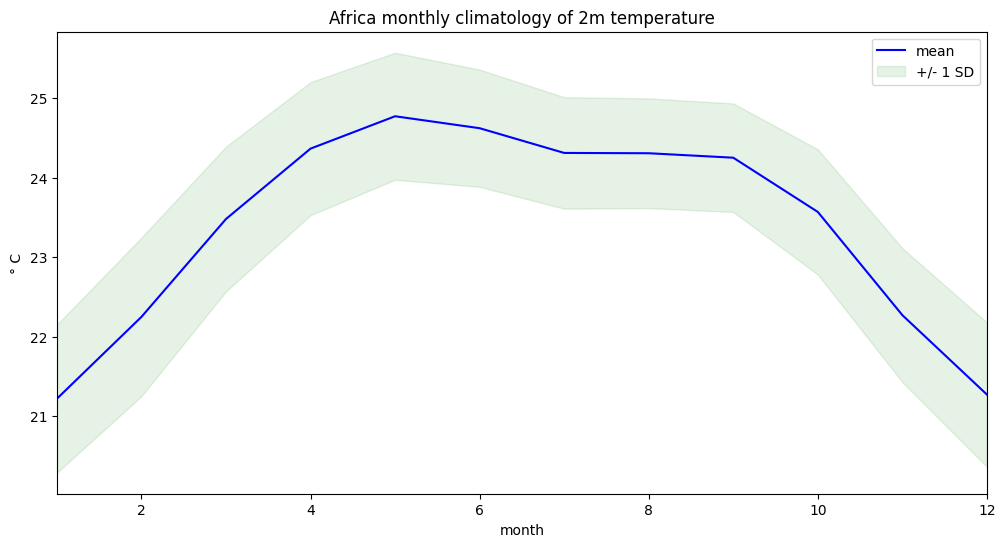

In [28]:
# @title Entire Africa
plot_climatology(africa_mean, africa_std, "Africa")

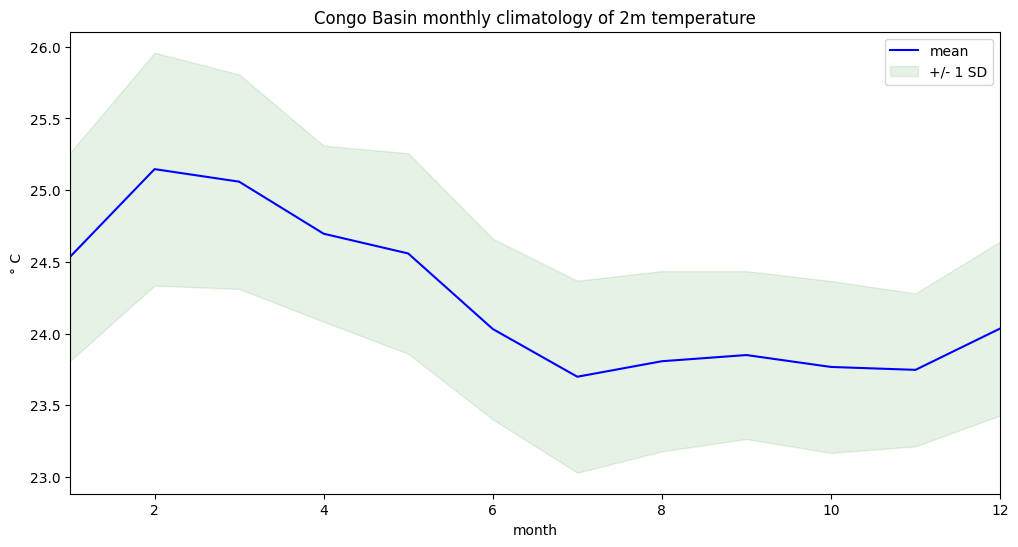

In [29]:
# @title Congo Basin
plot_climatology(congo_basin_mean, congo_basin_std, "Congo Basin")

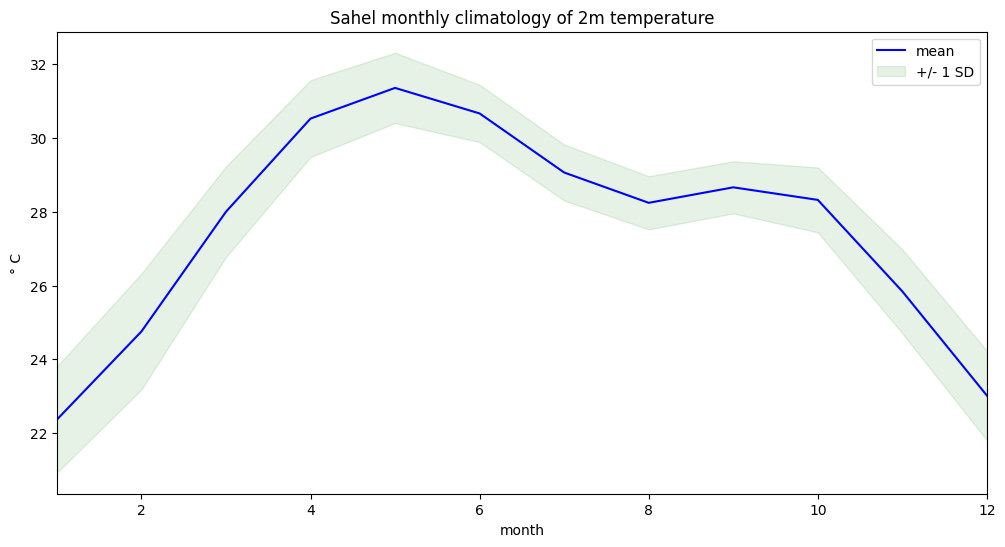

In [30]:
# @title Sahel
plot_climatology(sahel_mean, sahel_std, "Sahel")

In [31]:
from fynesse.assess import plot_trend_map, plot_region_timeseries, plot_decadal_boxplot

## Plot whole of Africa `DataArray` at different timestamps

Are there changes that are noticeble to the average human eye?

In [32]:
from fynesse.assess import get_int, plot_da

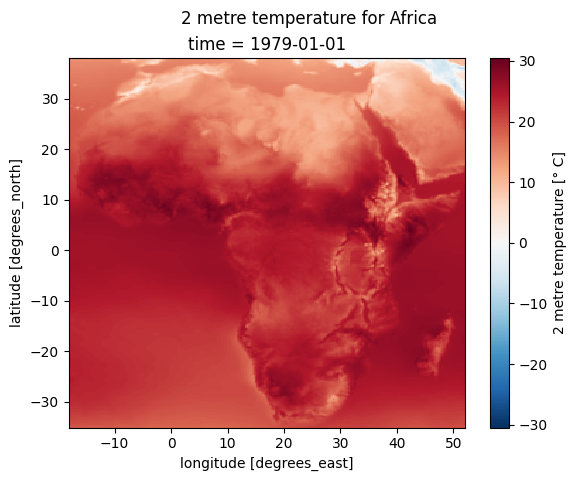

In [33]:
# Plot at January 1979
plot_da(t2m_da, 1979, 1, "Africa")

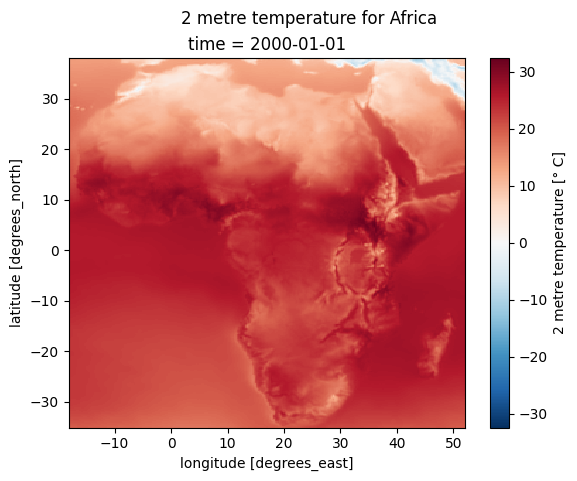

In [34]:
# Plot at January 2000
plot_da(t2m_da, 2000, 1, "Africa")

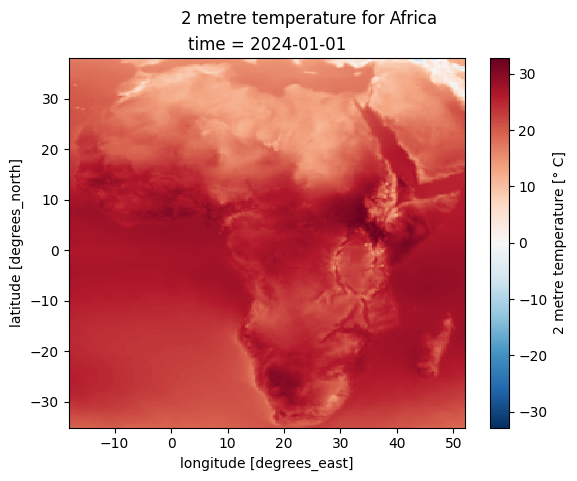

In [35]:
# Plot at January 2024
plot_da(t2m_da, 2024, 1, "Africa")

## Calculate climate normals and anomalies

Anthropogenic activities and natural variations from years to decades shape the Earth's climate. In order to evaluate anomalous conditions of a specific month or year, the World Meteorological Organization (WMO) defines `standard reference periods` used to create `climate normals`. `Climate normals` can be considered as the typical climate for the period the normals are based on.

Until 2020, the most current and widely used standard reference period was the 30-year range of 1981-2010. With the start of 2021, the WMO recommended updating the climate normal reference period to the range 1991-2020.

We shall also calculate the anomalies with respect to the climate normal. In this case, the term anomaly means the deviation of a value from the long-term average.

In [36]:
from fynesse.assess import compute_anomalies

In [37]:
from fynesse.assess import compute_regional_mean, plot_region_timeseries

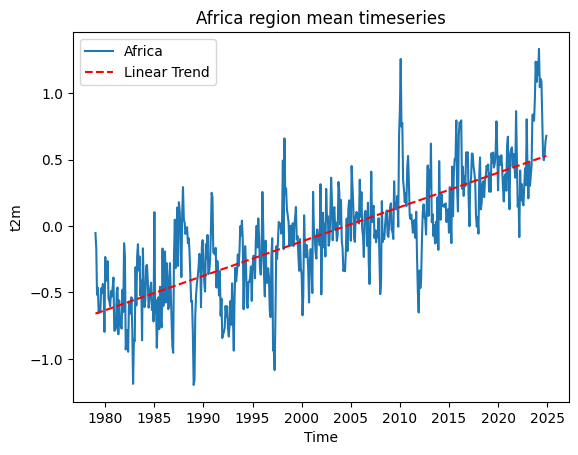

In [38]:
# @title Entire Africa

africa_anomalies = compute_anomalies(t2m_da, baseline=(1991, 2020))
plot_region_timeseries(compute_regional_mean(africa_anomalies), "Africa")

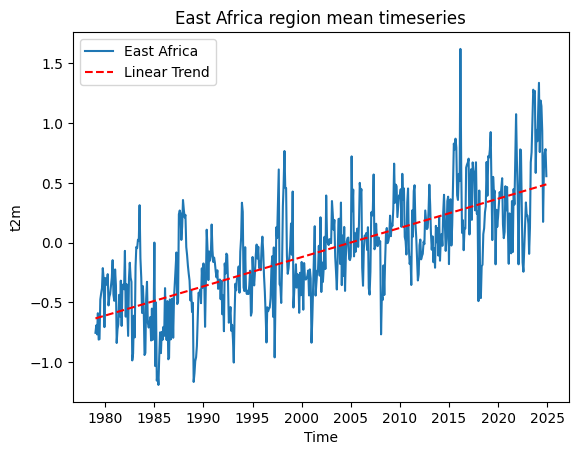

In [39]:
# @title East Africa
east_africa_anomalies = compute_anomalies(t2m_east_africa_da, baseline=(1991, 2020))
plot_region_timeseries(compute_regional_mean(east_africa_anomalies), "East Africa")

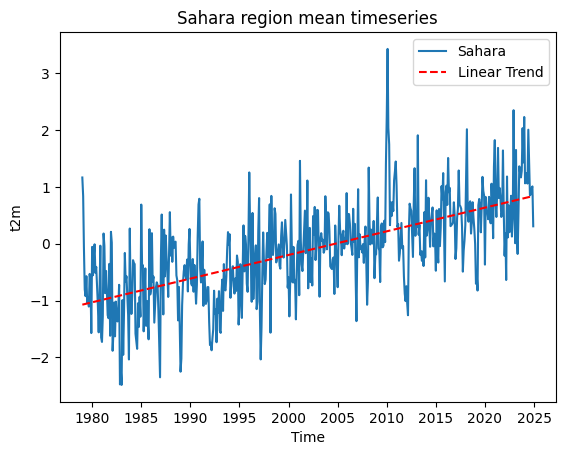

In [40]:
# @title Sahara
sahara_anomalies = compute_anomalies(t2m_sahara_da, baseline=(1991, 2020))
plot_region_timeseries(compute_regional_mean(sahara_anomalies), "Sahara")

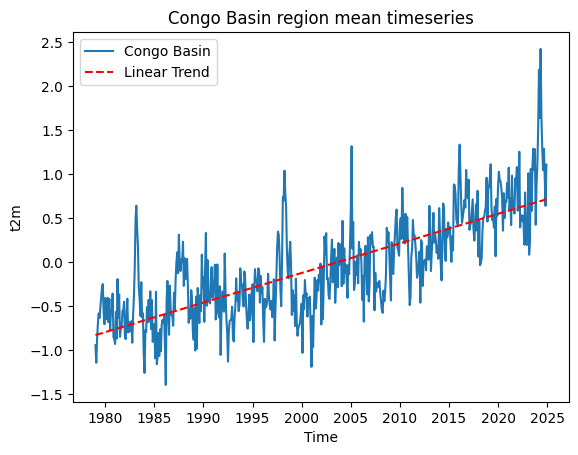

In [41]:
# @title Congo basin
congo_basin_anomalies = compute_anomalies(t2m_congo_basin_da, baseline=(1991, 2020))
plot_region_timeseries(compute_regional_mean(congo_basin_anomalies), "Congo Basin")

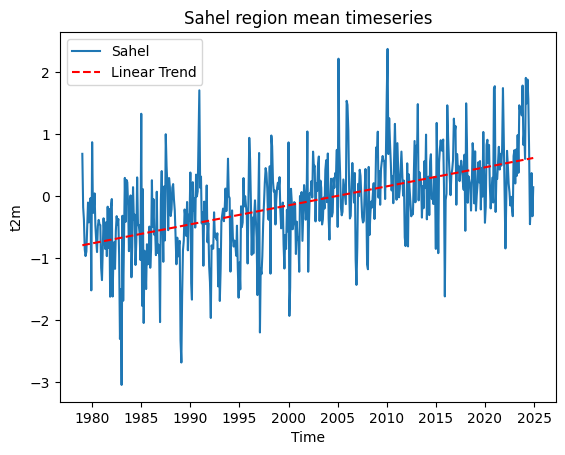

In [42]:
# @title Sahel
sahel_anomalies = compute_anomalies(t2m_sahel_da, baseline=(1991, 2020))
plot_region_timeseries(compute_regional_mean(sahel_anomalies), "Sahel")

## Which parts of Africa are warming the fastest?
### Trend Map between 1979 - 2024

Rate of change per year at each spatial grid cell

In [43]:
from fynesse.assess import compute_linear_trend, plot_trend_map

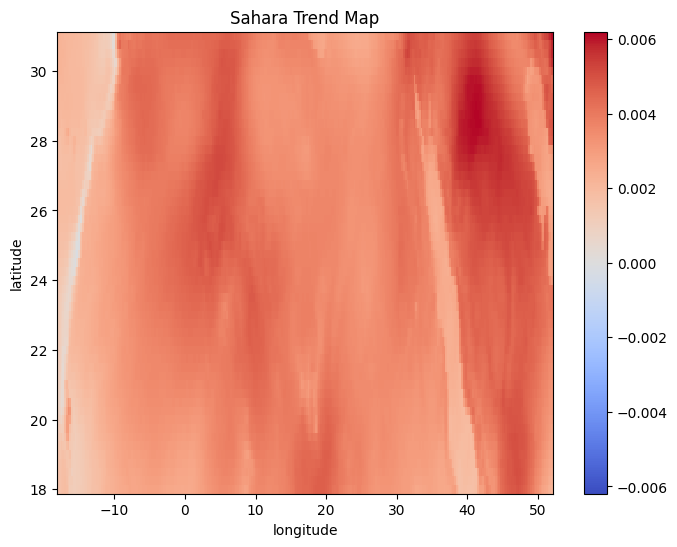

In [44]:
# @title Sahara
plot_trend_map(compute_linear_trend(t2m_sahara_da), "Sahara Trend Map")

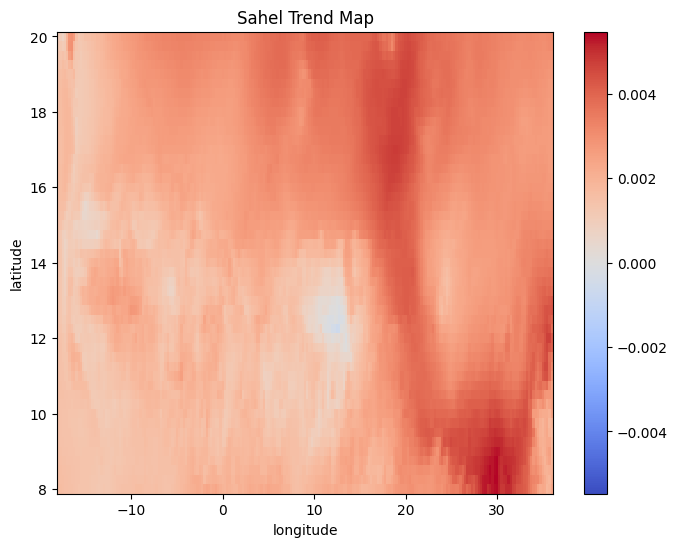

In [45]:
# @title Sahel
plot_trend_map(compute_linear_trend(t2m_sahel_da), "Sahel Trend Map")

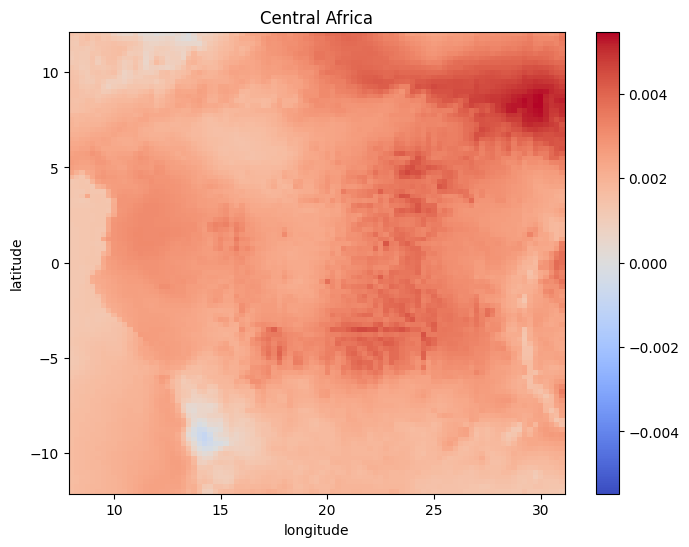

In [46]:
# @title Central Africa
plot_trend_map(compute_linear_trend(t2m_central_africa_da), "Central Africa")

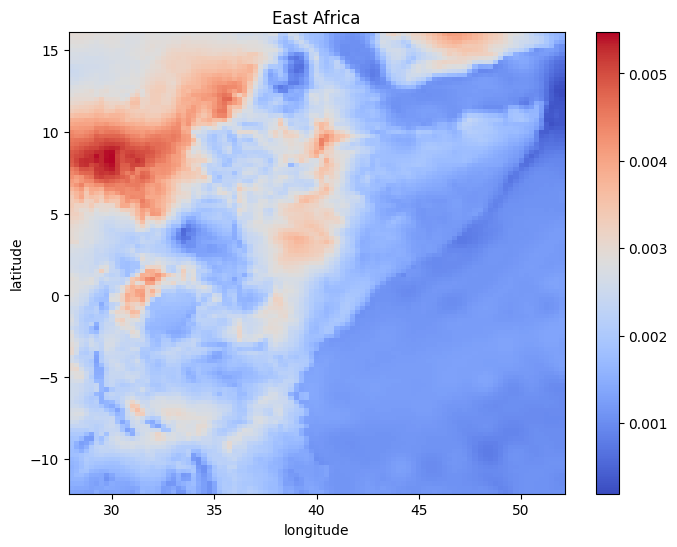

In [47]:
# @title East Africa
plot_trend_map(compute_linear_trend(t2m_east_africa_da), "East Africa")

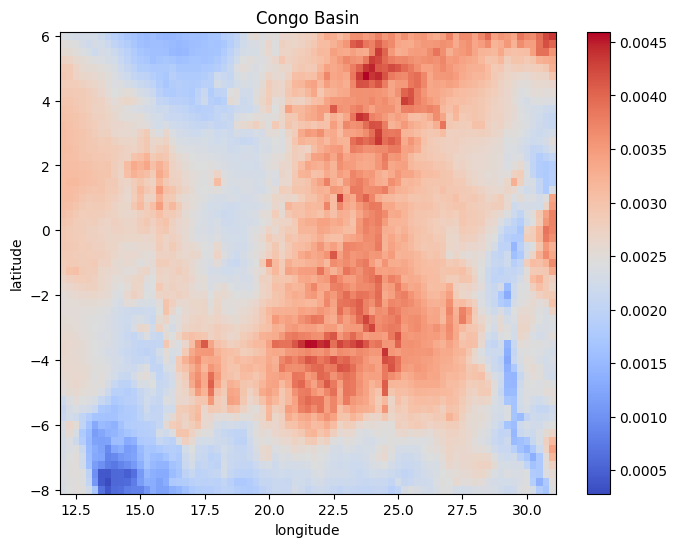

In [48]:
# @title Congo Basin
plot_trend_map(compute_linear_trend(t2m_congo_basin_da), "Congo Basin")

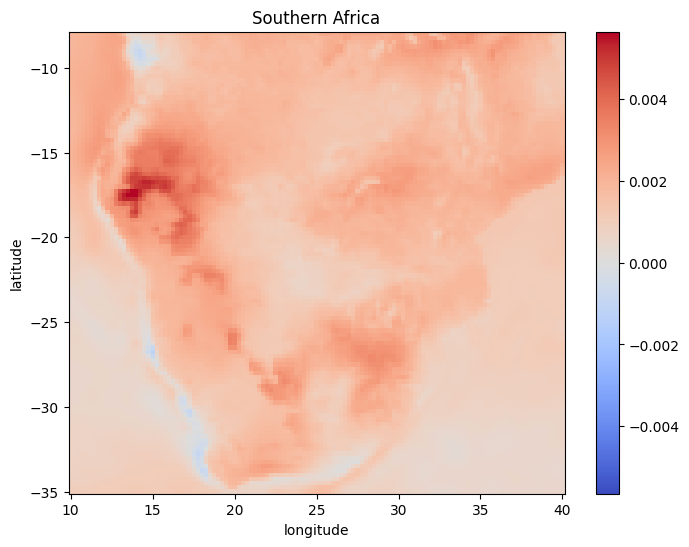

In [49]:
# @title Southern Africa
plot_trend_map(compute_linear_trend(t2m_southern_africa_da), "Southern Africa")

## Regional Mean time series

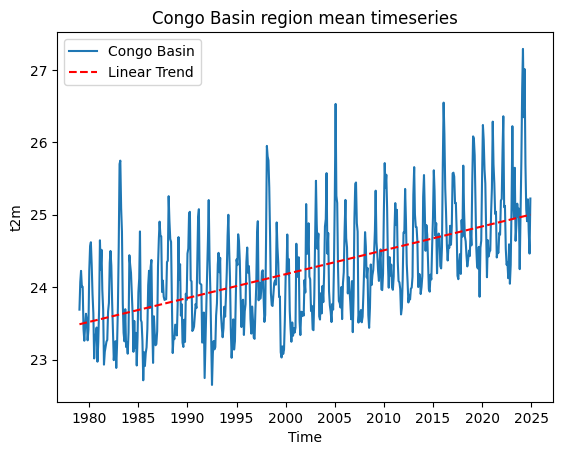

In [50]:
# @title Congo Basin
congo_basin_mean = compute_regional_mean(t2m_congo_basin_da)
plot_region_timeseries(congo_basin_mean, "Congo Basin")

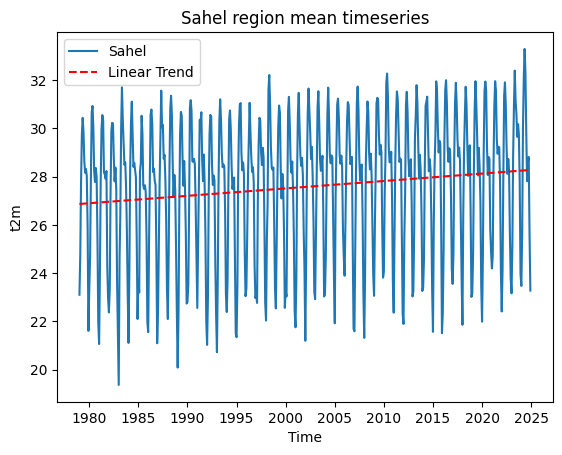

In [51]:
# @title Sahel
sahel_mean = compute_regional_mean(t2m_sahel_da)
plot_region_timeseries(sahel_mean, "Sahel")

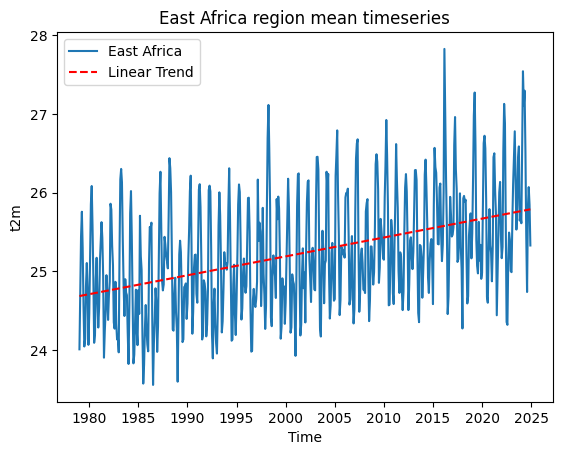

In [52]:
# @title East Africa
east_africa_mean = compute_regional_mean(t2m_east_africa_da)
plot_region_timeseries(east_africa_mean, "East Africa")

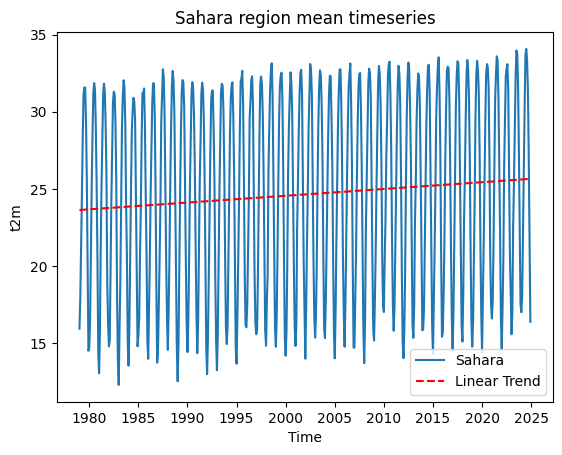

In [53]:
# @title Sahara
sahara_mean = compute_regional_mean(t2m_sahara_da)
plot_region_timeseries(sahara_mean, "Sahara")

## Plot decadal trends across regions

Use Boxplots to plot the trends over bins of 10 years.

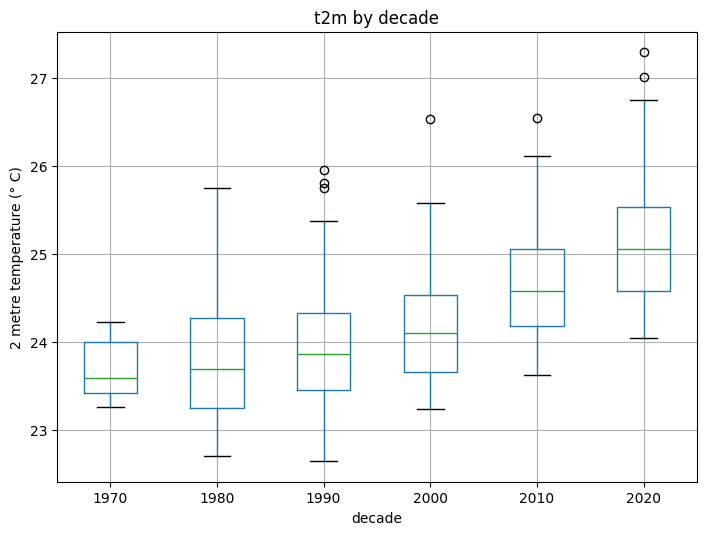

In [54]:
# @title Congo Basin
plot_decadal_boxplot(t2m_congo_basin_da, "t2m")

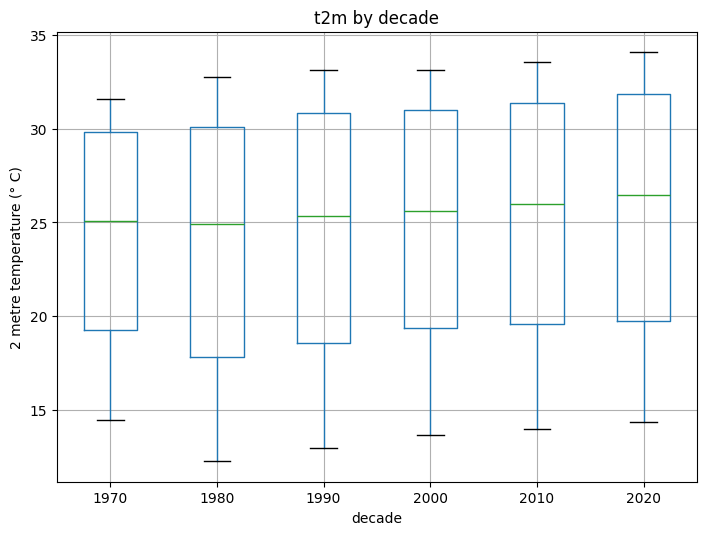

In [55]:
# @title Sahara
plot_decadal_boxplot(t2m_sahara_da, "t2m")

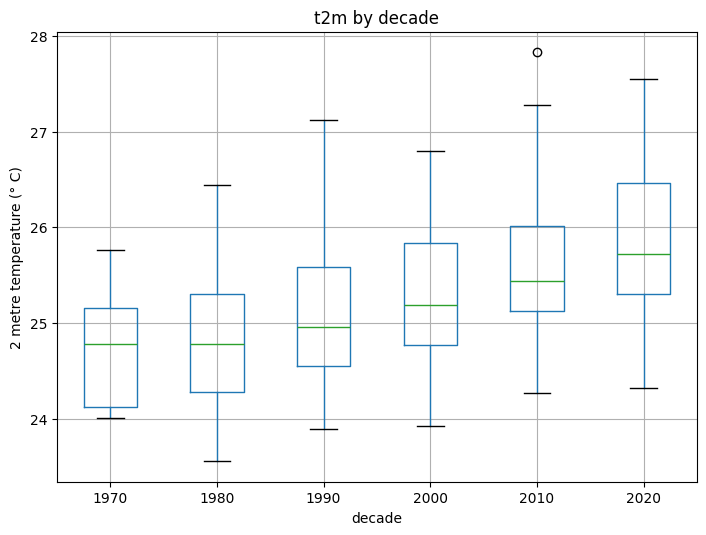

In [56]:
# @title East Africa
plot_decadal_boxplot(t2m_east_africa_da, "t2m")

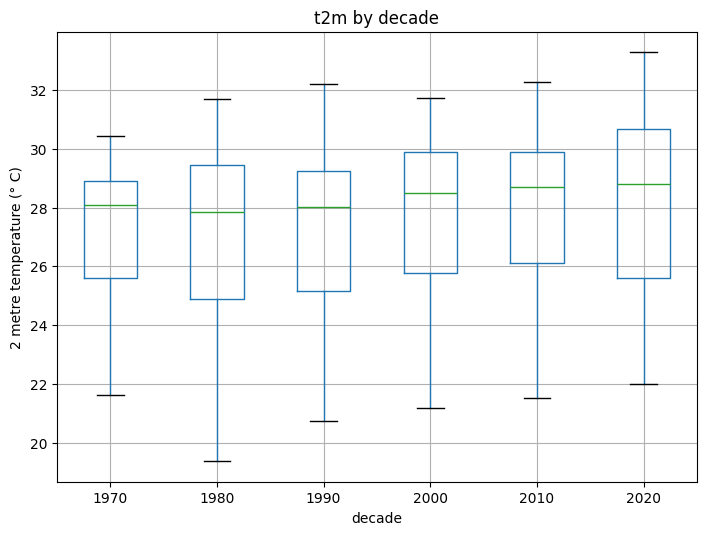

In [57]:
# @title Sahel
plot_decadal_boxplot(t2m_sahel_da, "t2m")

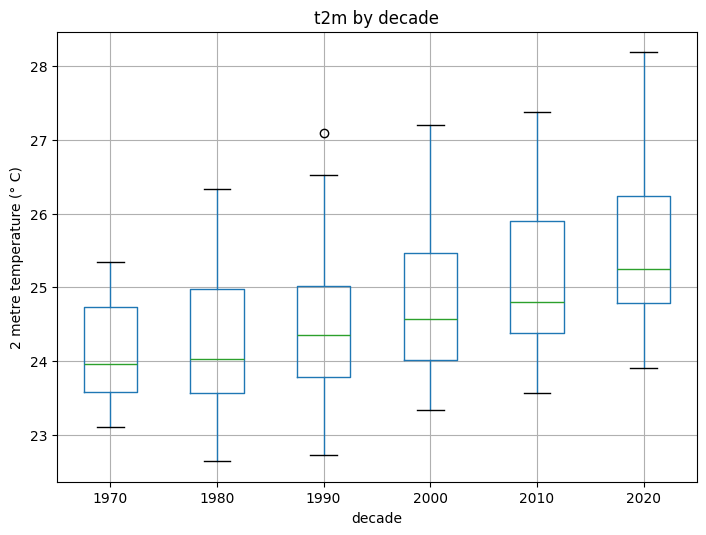

In [58]:
# @title Central Africa
plot_decadal_boxplot(t2m_central_africa_da, "t2m")

In [59]:
regions = {
    "Sahel": t2m_sahel_da,
    "East Africa": t2m_east_africa_da,
    "Central Africa": t2m_central_africa_da,
    "Congo Basin": t2m_congo_basin_da,
    "Southern Africa": t2m_southern_africa_da,
    "Sahara": t2m_sahara_da,
}


In [60]:
from scipy.stats import linregress

In [61]:
%%writefile -a fynesse/assess.py

def summarize_region(da, name, baseline=(1991, 2020)):
    reg_mean = compute_regional_mean(da)  # 1D time series

    # Linear trend (per decade)
    time_num = np.arange(len(reg_mean["time"])) / 12  # in years
    slope, intercept, r, p, se = linregress(time_num, reg_mean.values)
    slope_decade = slope * 10  # °C per decade

    # Mean and variability
    mean_val = float(reg_mean.mean().values)
    std_val = float(reg_mean.std().values)

    # Anomalies relative to baseline
    anomalies = compute_anomalies(da, baseline=baseline)
    anomalies_mean = compute_regional_mean(anomalies)
    recent_anom = anomalies_mean.sel(time=slice("2014-01-01", "2023-12-31")).mean().values

    return {
        "Region": name,
        "Trend (°C/decade)": slope_decade,
        "Mean (°C)": mean_val,
        "StdDev (°C)": std_val,
        "Recent anomaly vs 1991–2020 (°C)": recent_anom
    }


Appending to fynesse/assess.py


In [62]:
from fynesse.assess import summarize_region

In [63]:
rows = []
for region, da in regions.items():
    rows.append(summarize_region(da, region))

summary_df = pd.DataFrame(rows)
summary_df.set_index("Region", inplace=True)
summary_df.round(2)

,Trend (°C/decade),Mean (°C),StdDev (°C),Recent anomaly vs 1991–2020 (°C)
Region,,,,
Sahel,0.31,27.57,2.93,0.4162793954874317
East Africa,0.24,25.24,0.75,0.3509977836218525
Central Africa,0.30,24.72,1.00,0.5050261841074122
Congo Basin,0.33,24.24,0.77,0.593591344099643
Southern Africa,0.19,21.06,2.19,0.3218495357286662
Sahara,0.44,24.63,6.45,0.559555903838928


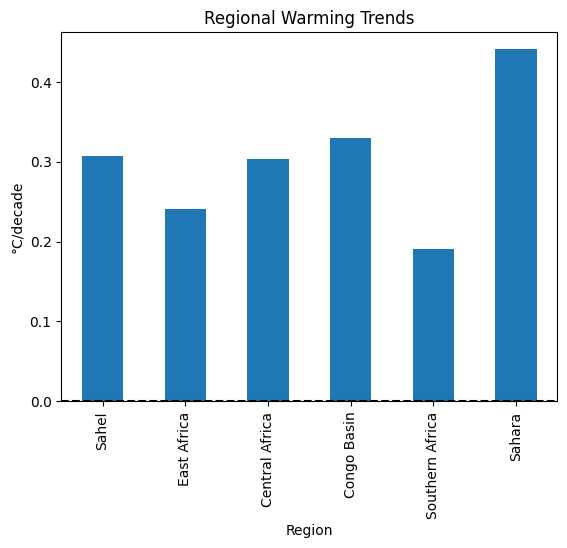

In [64]:
summary_df["Trend (°C/decade)"].plot(kind="bar", title="Regional Warming Trends", ylabel="°C/decade")
plt.axhline(0, color="k", linestyle="--")
plt.show()

In [65]:
# !git config --global user.email github_email
# !git config --global user.name github_username

In [66]:
# !git add .

In [67]:
# !git commit -m "updated access and assess"

In [68]:
# repo_url = f"https://{github_token}@github.com/teofizzy/mlfc-miniproject.git"

## Conclusion
Africa is warming across all regions, but the Sahara and Congo Basin are experiencing the fastest increases (≈0.3–0.4 °C/decade), while Southern Africa is warming more slowly (≈0.2 °C/decade). Recent conditions (2014–2023) are already 0.3–0.6 °C hotter than the 1991–2020 baseline, which has critical implications: intensifying heat extremes in the Sahara, threatening water and forest resilience in the Congo Basin, and adding stress to agriculture, food security, and ecosystems across the continent. This underscores the urgent need for adaptation planning tailored to regional climate trajectories.